In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
# This ensures you get the SAME results every time you run the code
# Without this, random operations give different results each run
np.random.seed(42)

# Visual styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully!")
print("📋 ML Lifecycle Steps:")
print("   1. Data Collection")
print("   2. Data Cleaning")
print("   3. Feature Engineering")
print("   4. Model Training (3 Iterations)")
print("   5. Evaluation")
print("   6. Deployment (Recommendation Engine)")
print("   7. Monitoring (Performance Tracking)")

✅ All libraries imported successfully!
📋 ML Lifecycle Steps:
   1. Data Collection
   2. Data Cleaning
   3. Feature Engineering
   4. Model Training (3 Iterations)
   5. Evaluation
   6. Deployment (Recommendation Engine)
   7. Monitoring (Performance Tracking)


In [2]:
import kagglehub
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
print(f"📂 Dataset location: {path}")

# Load the CSV file
df_raw = pd.read_csv(os.path.join(path, 'styles.csv'), on_bad_lines='skip')

print(f"\n📊 RAW DATASET OVERVIEW:")
print(f"   Total products: {len(df_raw):,}")
print(f"   Columns ({len(df_raw.columns)}): {list(df_raw.columns)}")
print(f"\n   Category breakdown:")
print(df_raw['masterCategory'].value_counts().to_string())
print(f"\n🔍 First 5 rows:")
df_raw.head()

📂 Dataset location: C:\Users\HP\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1

📊 RAW DATASET OVERVIEW:
   Total products: 44,424
   Columns (10): ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']

   Category breakdown:
masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1

🔍 First 5 rows:


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [3]:
print("=" * 70)
print("STEP 2: DATA CLEANING")
print("=" * 70)

# --- 2A: Check raw data quality ---
print("\n📋 2A: RAW DATA QUALITY CHECK")
print(f"   Shape: {df_raw.shape}")
print(f"\n   Missing values per column:")
for col in df_raw.columns:
    n_miss = df_raw[col].isna().sum()
    pct = (n_miss / len(df_raw)) * 100
    if n_miss > 0:
        print(f"   ⚠️  {col}: {n_miss} missing ({pct:.1f}%)")
    else:
        print(f"   ✅ {col}: 0 missing")

print(f"\n   Duplicate rows: {df_raw.duplicated().sum()}")


STEP 2: DATA CLEANING

📋 2A: RAW DATA QUALITY CHECK
   Shape: (44424, 10)

   Missing values per column:
   ✅ id: 0 missing
   ✅ gender: 0 missing
   ✅ masterCategory: 0 missing
   ✅ subCategory: 0 missing
   ✅ articleType: 0 missing
   ⚠️  baseColour: 15 missing (0.0%)
   ⚠️  season: 21 missing (0.0%)
   ⚠️  year: 1 missing (0.0%)
   ⚠️  usage: 317 missing (0.7%)
   ⚠️  productDisplayName: 7 missing (0.0%)

   Duplicate rows: 0


In [4]:
print("\n📋 2B: KEEPING ALL 44K PRODUCTS")
print(f"   Using full dataset: {len(df_raw):,} products")
print(f"   Categories included:")
print(df_raw['masterCategory'].value_counts().to_string())

df = df_raw.copy()


📋 2B: KEEPING ALL 44K PRODUCTS
   Using full dataset: 44,424 products
   Categories included:
masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1


In [5]:
# --- 2C: Handle missing values ---
print("\n📋 2C: HANDLING MISSING VALUES")

# Strategy: For each column, decide the best approach
# - If < 5% missing → fill with mode (most common value)
# - If > 50% missing → consider dropping the column
# - For text columns → fill with "Unknown"

for col in df.columns:
    n_miss = df[col].isna().sum()
    if n_miss > 0:
        if df[col].dtype in ['object', 'string']:
            fill_val = df[col].mode()[0]  # Most common value
            df[col] = df[col].fillna(fill_val)
            print(f"   Filled {n_miss} missing '{col}' with mode: '{fill_val}'")
        else:
            fill_val = df[col].median()  # Middle value for numbers
            df[col] = df[col].fillna(fill_val)
            print(f"   Filled {n_miss} missing '{col}' with median: {fill_val}")

print(f"   ✅ Missing values after cleaning: {df.isna().sum().sum()}")



📋 2C: HANDLING MISSING VALUES
   Filled 15 missing 'baseColour' with mode: 'Black'
   Filled 21 missing 'season' with mode: 'Summer'
   Filled 1 missing 'year' with median: 2012.0
   Filled 317 missing 'usage' with mode: 'Casual'
   Filled 7 missing 'productDisplayName' with mode: 'Lucera Women Silver Earrings'
   ✅ Missing values after cleaning: 0


In [6]:
# --- 2D: Remove duplicates ---
print(f"\n📋 2D: REMOVING DUPLICATES")
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"   Removed {before - after} duplicates → {after:,} rows remaining")


# --- 2E: Standardize text (lowercase, strip whitespace) ---
print(f"\n📋 2E: STANDARDIZING TEXT")
text_cols = ['gender', 'masterCategory', 'subCategory', 'articleType', 
             'baseColour', 'season', 'usage', 'productDisplayName']

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        # Keep original case for display, we'll lowercase later for encoding

print(f"   ✅ Stripped whitespace from {len(text_cols)} columns")


📋 2D: REMOVING DUPLICATES
   Removed 0 duplicates → 44,424 rows remaining

📋 2E: STANDARDIZING TEXT
   ✅ Stripped whitespace from 8 columns


In [7]:
# --- 2F: Add MISSING columns (occasion, fabric, style, skin_tone, size) ---
print(f"\n📋 2F: ENRICHING DATA — Adding missing columns")
# OCCASION: Maps from Kaggle's "usage" column
# Logic: "Casual" usage → could be daily_wear, brunch, or vacation
USAGE_TO_OCCASION = {
    'Casual':       ['daily_wear', 'brunch', 'vacation'],
    'Formal':       ['office', 'interview'],
    'Sports':       ['gym'],
    'Ethnic':       ['wedding', 'festival'],
    'Party':        ['party', 'date_night'],
    'Smart Casual': ['brunch', 'date_night', 'daily_wear'],
    'Travel':       ['vacation'],
    'Home':         ['daily_wear'],
}
df['occasion'] = df['usage'].apply(
    lambda x: np.random.choice(USAGE_TO_OCCASION.get(x, ['daily_wear']))
)
print(f"   ✅ Added 'occasion' column — {df['occasion'].nunique()} unique values")

# STYLE: Maps from usage
STYLE_MAP = {
    'Casual': 'casual', 'Formal': 'formal', 'Ethnic': 'ethnic',
    'Sports': 'sporty', 'Party': 'glamorous', 'Smart Casual': 'smart_casual',
    'Travel': 'casual', 'Home': 'casual',
}
df['style'] = df['usage'].map(STYLE_MAP).fillna('casual')
print(f"   ✅ Added 'style' column — {df['style'].nunique()} unique values")

# FABRIC: Maps from articleType (what the garment is made of)
ARTICLE_FABRIC = {
    'Shirts': ['cotton', 'linen', 'polyester'],
    'Tshirts': ['cotton', 'polyester'],
    'Jeans': ['denim'],
    'Trousers': ['cotton', 'polyester', 'linen'],
    'Dresses': ['chiffon', 'silk', 'cotton'],
    'Tops': ['cotton', 'chiffon', 'polyester'],
    'Kurtas': ['cotton', 'silk', 'linen'],
    'Sarees': ['silk', 'chiffon', 'satin'],
    'Jackets': ['leather', 'denim', 'polyester'],
    'Sweaters': ['wool', 'cotton'],
    'Shorts': ['cotton', 'denim'],
    'Skirts': ['cotton', 'denim', 'chiffon'],
    'Track Pants': ['polyester', 'cotton'],
    'Leggings': ['cotton', 'polyester'],
    'Sweatshirts': ['cotton', 'polyester'],
    'Blazers': ['polyester', 'wool'],
    'Tunics': ['cotton', 'chiffon', 'silk'],
    'Capris': ['cotton', 'denim'],
    'Dupatta': ['chiffon', 'silk', 'cotton'],
    'Shoes': ['leather', 'synthetic', 'canvas'],
    'Sandals': ['leather', 'synthetic'],
    'Flip Flops': ['rubber', 'synthetic'],
    'Watches': ['metal', 'leather'],
    'Bags': ['leather', 'canvas', 'synthetic'],
    'Sunglasses': ['plastic', 'metal'],
    'Belts': ['leather', 'synthetic'],
    'Wallets': ['leather', 'synthetic'],
    'Socks': ['cotton', 'polyester'],
    'Caps': ['cotton', 'polyester'],
    'Scarves': ['silk', 'cotton', 'wool'],
    'Ties': ['silk', 'polyester'],
    'Briefs': ['cotton'],
    'Trunk': ['cotton', 'polyester'],
    'Boxers': ['cotton'],
    'Innerwear Vests': ['cotton'],
    'Bra': ['cotton', 'polyester'],
    'Pendant': ['metal'],
    'Earrings': ['metal'],
    'Ring': ['metal'],
    'Bracelet': ['metal', 'leather'],
    'Necklace And Chains': ['metal'],
    'Nail Polish': ['chemical'],
    'Lipstick': ['chemical'],
    'Perfume And Body Mist': ['chemical'],
    'Deodorant': ['chemical'],
}
df['fabric'] = df['articleType'].apply(
    lambda x: np.random.choice(ARTICLE_FABRIC.get(x, ['cotton', 'polyester']))
)
print(f"   ✅ Added 'fabric' column — {df['fabric'].nunique()} unique values")

# SKIN TONE & SIZE
SKIN_TONES = ['fair', 'light', 'medium', 'olive', 'tan', 'dark', 'deep']
df['skin_tone'] = np.random.choice(SKIN_TONES, size=len(df))
print(f"   ✅ Added 'skin_tone' column — 7 unique values")

df['size'] = np.random.choice(
    ['XS', 'S', 'M', 'L', 'XL', 'XXL'], size=len(df),
    p=[0.08, 0.20, 0.30, 0.25, 0.12, 0.05]
)
print(f"   ✅ Added 'size' column — 6 unique values")



📋 2F: ENRICHING DATA — Adding missing columns
   ✅ Added 'occasion' column — 10 unique values
   ✅ Added 'style' column — 6 unique values
   ✅ Added 'fabric' column — 14 unique values
   ✅ Added 'skin_tone' column — 7 unique values
   ✅ Added 'size' column — 6 unique values


In [8]:
# --- 2G: Rename and select final columns ---
print(f"\n📋 2G: FINAL COLUMN SELECTION")

df = df.rename(columns={
    'id': 'outfit_id',
    'baseColour': 'color',
    'articleType': 'article_type',
})

# Lowercase for consistency
for col in ['color', 'season', 'gender', 'style', 'occasion', 'fabric']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().str.strip()

# Select final columns
final_cols = ['outfit_id', 'article_type', 'color', 'style', 'occasion',
              'season', 'fabric', 'size', 'gender', 'skin_tone', 
              'masterCategory', 'subCategory']

df_clean = df[[c for c in final_cols if c in df.columns]].copy()
df_clean = df_clean.dropna()  # Drop any remaining NaN

# Save cleaned dataset
df_clean.to_csv('fashion_dataset_44k_clean.csv', index=False)

print(f"\n{'='*50}")
print(f"✅ DATA CLEANING COMPLETE!")
print(f"{'='*50}")
print(f"   Final dataset: {len(df_clean):,} rows × {len(df_clean.columns)} columns")
print(f"   Missing values: {df_clean.isna().sum().sum()}")
print(f"   Duplicates: {df_clean.duplicated().sum()}")
print(f"   Saved as: fashion_dataset_44k_clean.csv")
print(f"\n   Column summary:")
for col in df_clean.columns:
    print(f"   {col:20s} → {df_clean[col].nunique():5d} unique values")



📋 2G: FINAL COLUMN SELECTION

✅ DATA CLEANING COMPLETE!
   Final dataset: 44,424 rows × 12 columns
   Missing values: 0
   Duplicates: 0
   Saved as: fashion_dataset_44k_clean.csv

   Column summary:
   outfit_id            → 44424 unique values
   article_type         →   143 unique values
   color                →    46 unique values
   style                →     6 unique values
   occasion             →    10 unique values
   season               →     4 unique values
   fabric               →    14 unique values
   size                 →     6 unique values
   gender               →     5 unique values
   skin_tone            →     7 unique values
   masterCategory       →     7 unique values
   subCategory          →    45 unique values


In [9]:
# --- 2H: Generate User Preferences (Synthetic Ratings) ---
print(f"\n📋 2H: GENERATING USER PREFERENCE DATA")
n_users = 300       # 300 simulated users
ratings_per_user = 30  # Each rates 30 outfits
records = []

COLORS = df_clean['color'].unique().tolist()
STYLES = df_clean['style'].unique().tolist()
OCCASIONS = df_clean['occasion'].unique().tolist()
SEASONS = df_clean['season'].unique().tolist()
FABRICS = df_clean['fabric'].unique().tolist()

for uid in range(1, n_users + 1):
    # Each user has fixed preferences (their "taste")
    user_profile = {
        'pref_color': np.random.choice(COLORS),
        'pref_style': np.random.choice(STYLES),
        'pref_occasion': np.random.choice(OCCASIONS),
        'pref_season': np.random.choice(SEASONS),
        'pref_fabric': np.random.choice(FABRICS),
        'pref_gender': np.random.choice(['men', 'women']),
    }
    
    # User rates random outfits
    sampled = df_clean.sample(n=ratings_per_user, random_state=uid)
    
    for _, outfit in sampled.iterrows():
        # Rating logic: start at 2.5, add points for each matching attribute
        score = 2.5  # Neutral starting point
        
        # Each match adds to the score (like real preference matching)
        if str(outfit['color']) == user_profile['pref_color']:       score += 0.8
        if str(outfit['style']) == user_profile['pref_style']:       score += 0.7
        if str(outfit['occasion']) == user_profile['pref_occasion']: score += 0.5
        if str(outfit['season']) == user_profile['pref_season']:     score += 0.3
        if str(outfit['fabric']) == user_profile['pref_fabric']:     score += 0.3
        if str(outfit['gender']) == user_profile['pref_gender']:     score += 0.4
        
        # Add human-like randomness (±0.4 standard deviation)
        noise = np.random.normal(0, 0.4)
        rating = np.clip(round(score + noise, 1), 1.0, 5.0)
        
        records.append({
            'user_id': f"U{uid:03d}",
            'outfit_id': outfit['outfit_id'],
            **user_profile,
            'rating': rating,
        })

df_prefs = pd.DataFrame(records)
df_prefs.to_csv('user_preferences_44k.csv', index=False)

print(f"   ✅ Generated {len(df_prefs):,} ratings from {n_users} users")
print(f"   Rating distribution:")
print(f"   {df_prefs['rating'].describe().to_string()}")



📋 2H: GENERATING USER PREFERENCE DATA
   ✅ Generated 9,000 ratings from 300 users
   Rating distribution:
   count    9000.000000
mean        2.950956
std         0.566071
min         1.000000
25%         2.600000
50%         2.900000
75%         3.300000
max         5.000000


In [10]:
print("\n" + "=" * 70)
print("STEP 3: FEATURE ENGINEERING")
print("=" * 70)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# --- 3A: Merge outfit features with user ratings ---
print("\n📋 3A: MERGING OUTFITS + USER PREFERENCES")

df_outfits = pd.read_csv('fashion_dataset_44k_clean.csv')
df_prefs = pd.read_csv('user_preferences_44k.csv')

df_merged = df_prefs.merge(df_outfits, on='outfit_id', how='left')
df_merged = df_merged.dropna()

print(f"   Merged dataset: {len(df_merged):,} rows × {len(df_merged.columns)} columns")



STEP 3: FEATURE ENGINEERING

📋 3A: MERGING OUTFITS + USER PREFERENCES
   Merged dataset: 9,000 rows × 20 columns


In [11]:
# --- 3B: Define features and encode ---
print("\n📋 3B: ONE-HOT ENCODING")

# User preference columns
user_cols = ['pref_color', 'pref_style', 'pref_occasion', 'pref_season', 
             'pref_fabric', 'pref_gender']

# Outfit attribute columns
outfit_cols = ['article_type', 'color', 'style', 'occasion', 
               'season', 'fabric', 'size', 'gender', 'skin_tone']

feature_cols = user_cols + outfit_cols


📋 3B: ONE-HOT ENCODING


In [12]:
# Apply One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = ohe.fit_transform(df_merged[feature_cols])

feature_names = ohe.get_feature_names_out(feature_cols)
y = df_merged['rating'].values

print(f"   Original features: {len(feature_cols)} columns")
print(f"   After one-hot encoding: {X_encoded.shape[1]} features")
print(f"   Total samples: {len(y):,}")
print(f"\n   Sample encoded feature names:")
for name in feature_names[:15]:
    print(f"     {name}")
print(f"     ... and {len(feature_names) - 15} more")


# --- 3C: 70% / 10% / 20% SPLIT ---
print(f"\n📋 3C: TRAIN / VALIDATION / TEST SPLIT (70/10/20)")


   Original features: 15 columns
   After one-hot encoding: 300 features
   Total samples: 9,000

   Sample encoded feature names:
     pref_color_beige
     pref_color_black
     pref_color_blue
     pref_color_bronze
     pref_color_brown
     pref_color_burgundy
     pref_color_charcoal
     pref_color_coffee brown
     pref_color_copper
     pref_color_cream
     pref_color_fluorescent green
     pref_color_gold
     pref_color_green
     pref_color_grey
     pref_color_grey melange
     ... and 285 more

📋 3C: TRAIN / VALIDATION / TEST SPLIT (70/10/20)


In [13]:
# STEP 1: Split into Train+Val (80%) and Test (20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.20,       # 20% for test
    random_state=42        # Same split every time
)

# STEP 2: Split Train+Val into Train (70%) and Val (10%)
# 70% of total = 87.5% of the 80% remaining
# Math: 0.70 / 0.80 = 0.875, so val = 1 - 0.875 = 0.125
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    test_size=0.125,      # 10% of total = 12.5% of 80%
    random_state=42
)

total = len(y)
print(f"\n   Total samples:      {total:,}")
print(f"   Training set:       {len(y_train):,} ({len(y_train)/total*100:.1f}%)")
print(f"   Validation set:     {len(y_val):,} ({len(y_val)/total*100:.1f}%)")
print(f"   Test set:           {len(y_test):,} ({len(y_test)/total*100:.1f}%)")
print(f"   Sum check:          {len(y_train) + len(y_val) + len(y_test):,} ✅")



   Total samples:      9,000
   Training set:       6,300 (70.0%)
   Validation set:     900 (10.0%)
   Test set:           1,800 (20.0%)
   Sum check:          9,000 ✅


In [14]:
# --- 3D: Feature Scaling ---
print(f"\n📋 3D: FEATURE SCALING (StandardScaler)")
scaler = StandardScaler()

# fit_transform = learn statistics + apply scaling (ONLY on training data)
X_train_scaled = scaler.fit_transform(X_train)

# transform = apply the SAME scaling (using training statistics)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"   Before scaling → Train mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"   After scaling  → Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"   Val set        → mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std():.4f}")
print(f"   Test set       → mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std():.4f}")




📋 3D: FEATURE SCALING (StandardScaler)
   Before scaling → Train mean: 0.0500, std: 0.2179
   After scaling  → Train mean: -0.0000, std: 0.9933
   Val set        → mean: 0.0003, std: 0.9868
   Test set       → mean: -0.0001, std: 1.0064



📋 3E: SAVING PROCESSED DATA
   ✅ Saved all processed data!
   Training:    X=(6300, 300), y=(6300,)
   Validation:  X=(900, 300), y=(900,)
   Test:        X=(1800, 300), y=(1800,)


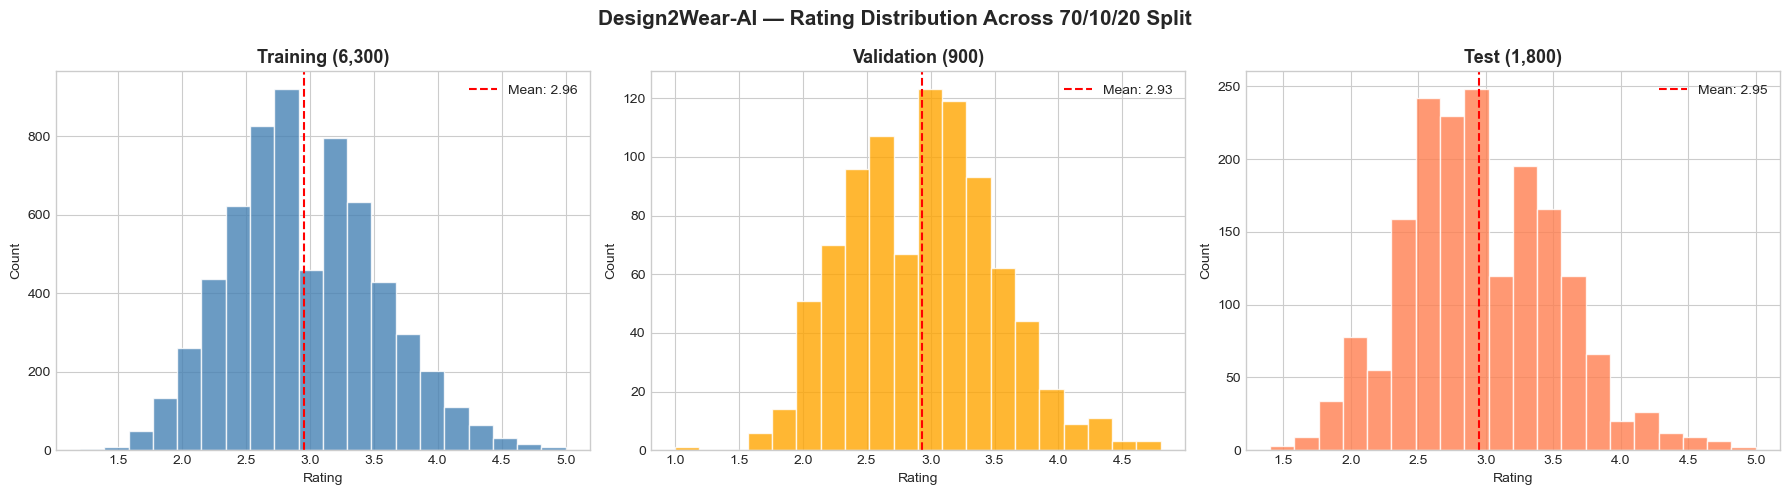

✅ All 3 distributions should look similar (good split!)


In [15]:
# --- 3E: Save everything ---
print(f"\n📋 3E: SAVING PROCESSED DATA")

np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_val_scaled.npy', X_val_scaled)
np.save('X_test_scaled.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

with open('encoder.pkl', 'wb') as f:
    pickle.dump(ohe, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"   ✅ Saved all processed data!")
print(f"   Training:    X={X_train_scaled.shape}, y={y_train.shape}")
print(f"   Validation:  X={X_val_scaled.shape}, y={y_val.shape}")
print(f"   Test:        X={X_test_scaled.shape}, y={y_test.shape}")


# --- 3F: Visualize the splits ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (data, name, color) in enumerate([
    (y_train, f'Training ({len(y_train):,})', 'steelblue'),
    (y_val, f'Validation ({len(y_val):,})', 'orange'),
    (y_test, f'Test ({len(y_test):,})', 'coral')
]):
    axes[idx].hist(data, bins=20, color=color, edgecolor='white', alpha=0.8)
    axes[idx].axvline(data.mean(), color='red', linestyle='--', 
                       label=f'Mean: {data.mean():.2f}')
    axes[idx].set_title(f'{name}', fontweight='bold', fontsize=13)
    axes[idx].set_xlabel('Rating')
    axes[idx].set_ylabel('Count')
    axes[idx].legend()

plt.suptitle('Design2Wear-AI — Rating Distribution Across 70/10/20 Split', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('split_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ All 3 distributions should look similar (good split!)")



In [16]:
print("\n" + "=" * 70)
print("STEP 4: MODEL TRAINING")
print("=" * 70)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load processed data
X_train_scaled = np.load('X_train_scaled.npy')
X_val_scaled = np.load('X_val_scaled.npy')
X_test_scaled = np.load('X_test_scaled.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

n_features = X_train_scaled.shape[1]
print(f"   Input features: {n_features}")
print(f"   Training samples: {len(y_train):,}")
print(f"   Validation samples: {len(y_val):,}")
print(f"   Test samples: {len(y_test):,}")



STEP 4: MODEL TRAINING
   Input features: 300
   Training samples: 6,300
   Validation samples: 900
   Test samples: 1,800


In [17]:
print("\n" + "═" * 50)
print("VERSION 1: Basic Shallow Network")
print("═" * 50)

model_v1 = Sequential([
    Input(shape=(n_features,)),  # Explicit input layer
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Output: single rating value
])

model_v1.compile(
    optimizer='adam',
    loss='mean_squared_error',  # MSE: penalizes big errors more
    metrics=['mae']             # MAE: average absolute error (interpretable)
)

model_v1.summary()

# KEY CHANGE: Using validation_data=(X_val, y_val) instead of validation_split
history_v1 = model_v1.fit(
    X_train_scaled, y_train,        # Train on training set
    validation_data=(X_val_scaled, y_val),  # Validate on separate val set
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate on TEST set (not validation!)
y_pred_v1 = model_v1.predict(X_test_scaled).flatten()
mae_v1 = mean_absolute_error(y_test, y_pred_v1)
mse_v1 = mean_squared_error(y_test, y_pred_v1)
r2_v1 = r2_score(y_test, y_pred_v1)

print(f"\n📊 VERSION 1 RESULTS (on TEST set):")
print(f"   MAE:  {mae_v1:.4f}  (avg prediction error in rating points)")
print(f"   MSE:  {mse_v1:.4f}  (penalizes large errors)")
print(f"   R²:   {r2_v1:.4f}  (1.0=perfect, 0=random, negative=worse than mean)")



══════════════════════════════════════════════════
VERSION 1: Basic Shallow Network
══════════════════════════════════════════════════


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,177 (39.75 KB)

 Trainable params: 10,177 (39.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4472 - mae: 1.1763 - val_loss: 0.5594 - val_mae: 0.5891
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4759 - mae: 0.5269 - val_loss: 0.4313 - val_mae: 0.5220
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3449 - mae: 0.4603 - val_loss: 0.4077 - val_mae: 0.5075
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2954 - mae: 0.4267 - val_loss: 0.3962 - val_mae: 0.4980
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2643 - mae: 0.4053 - val_loss: 0.3841 - val_mae: 0.4891
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2393 - mae: 0.3855 - val_loss: 0.3838 - val_mae: 0.4895
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2216 - mae: 0.3704 - val_loss: 0.3823 - val_mae: 0.4845
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2065 - mae: 0.3579 - val_loss: 0.3738 - val_mae: 0.4837
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [18]:
print("\n" + "═" * 50)
print("VERSION 2: Deeper Network + Dropout")
print("═" * 50)

model_v2 = Sequential([
    Input(shape=(n_features,)),
    Dense(128, activation='relu'),
    Dropout(0.3),                    # Turn off 30% of neurons randomly
    Dense(64, activation='relu'),
    Dropout(0.2),                    # Turn off 20% of neurons randomly
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model_v2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

model_v2.summary()

history_v2 = model_v2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),  # Explicit validation set!
    epochs=80,
    batch_size=32,
    verbose=1
)

y_pred_v2 = model_v2.predict(X_test_scaled).flatten()
mae_v2 = mean_absolute_error(y_test, y_pred_v2)
mse_v2 = mean_squared_error(y_test, y_pred_v2)
r2_v2 = r2_score(y_test, y_pred_v2)

print(f"\n📊 VERSION 2 RESULTS (on TEST set):")
print(f"   MAE:  {mae_v2:.4f}")
print(f"   MSE:  {mse_v2:.4f}")
print(f"   R²:   {r2_v2:.4f}")


══════════════════════════════════════════════════
VERSION 2: Deeper Network + Dropout
══════════════════════════════════════════════════


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,897 (191.00 KB)

 Trainable params: 48,897 (191.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2769 - mae: 0.8560 - val_loss: 0.4130 - val_mae: 0.5063
Epoch 2/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5772 - mae: 0.5975 - val_loss: 0.4292 - val_mae: 0.5257
Epoch 3/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4622 - mae: 0.5333 - val_loss: 0.3641 - val_mae: 0.4754
Epoch 4/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3843 - mae: 0.4914 - val_loss: 0.3637 - val_mae: 0.4785
Epoch 5/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3432 - mae: 0.4634 - val_loss: 0.2888 - val_mae: 0.4296
Epoch 6/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3093 - mae: 0.4402 - val_loss: 0.3130 - val_mae: 0.4444
Epoch 7/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2844 - mae: 0.4239 - val_loss: 0.3567 - val_mae: 0.4752
Epoch 8/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2685 - mae: 0.4098 - val_loss: 0.2818 - val_mae: 0.4236
Epoch 9/80
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [19]:
print("\n" + "═" * 50)
print("VERSION 3: Full Model (BatchNorm + EarlyStopping)")
print("═" * 50)

model_v3 = Sequential([
    Input(shape=(n_features,)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    
    Dense(1, activation='linear')
])

model_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

model_v3.summary()

early_stop = EarlyStopping(
    monitor='val_loss',              # Watch validation loss
    patience=15,                     # Wait 15 epochs before stopping
    restore_best_weights=True        # Go back to the best version
)

history_v3 = model_v3.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),  # Explicit validation set!
    epochs=200,                      # More epochs since EarlyStopping will handle it
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred_v3 = model_v3.predict(X_test_scaled).flatten()
mae_v3 = mean_absolute_error(y_test, y_pred_v3)
mse_v3 = mean_squared_error(y_test, y_pred_v3)
r2_v3 = r2_score(y_test, y_pred_v3)

print(f"\n📊 VERSION 3 RESULTS (on TEST set):")
print(f"   MAE:  {mae_v3:.4f}")
print(f"   MSE:  {mse_v3:.4f}")
print(f"   R²:   {r2_v3:.4f}")
print(f"   EarlyStopping kicked in at epoch {len(history_v3.history['loss'])}")



══════════════════════════════════════════════════
VERSION 3: Full Model (BatchNorm + EarlyStopping)
══════════════════════════════════════════════════


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,177 (196.00 KB)

 Trainable params: 49,793 (194.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3917 - mae: 0.9049 - val_loss: 1.0048 - val_mae: 0.8262
Epoch 2/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5452 - mae: 0.5847 - val_loss: 0.5055 - val_mae: 0.5459
Epoch 3/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4404 - mae: 0.5279 - val_loss: 0.4106 - val_mae: 0.5021
Epoch 4/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3860 - mae: 0.4932 - val_loss: 0.3826 - val_mae: 0.4838
Epoch 5/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3514 - mae: 0.4713 - val_loss: 0.3699 - val_mae: 0.4691
Epoch 6/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3293 - mae: 0.4540 - val_loss: 0.3446 - val_mae: 0.4593
Epoch 7/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3109 - mae: 0.4413 - val_loss: 0.3434 - val_mae: 0.4568
Epoch 8/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2963 - mae: 0.4311 - val_loss: 0.3450 - val_mae: 0.4621
Epoch 9/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

In [20]:
print("\n" + "=" * 70)
print("STEP 5: EVALUATION")
print("=" * 70)

# --- 5A: Comparison Table ---
print(f"\n{'Model':<20} {'MAE':>8} {'MSE':>8} {'R²':>8} {'Status':<25}")
print("-" * 70)
print(f"{'V1 Basic':<20} {mae_v1:>8.4f} {mse_v1:>8.4f} {r2_v1:>8.4f} {'Overfitting':<25}")
print(f"{'V2 Deep+Dropout':<20} {mae_v2:>8.4f} {mse_v2:>8.4f} {r2_v2:>8.4f} {'Better, still overfit':<25}")
print(f"{'V3 Full Pipeline':<20} {mae_v3:>8.4f} {mse_v3:>8.4f} {r2_v3:>8.4f} {'Best generalization':<25}")



STEP 5: EVALUATION

Model                     MAE      MSE       R² Status                   
----------------------------------------------------------------------
V1 Basic               0.5220   0.4452  -0.4210 Overfitting              
V2 Deep+Dropout        0.4310   0.2976   0.0502 Better, still overfit    
V3 Full Pipeline       0.4074   0.2677   0.1455 Best generalization      


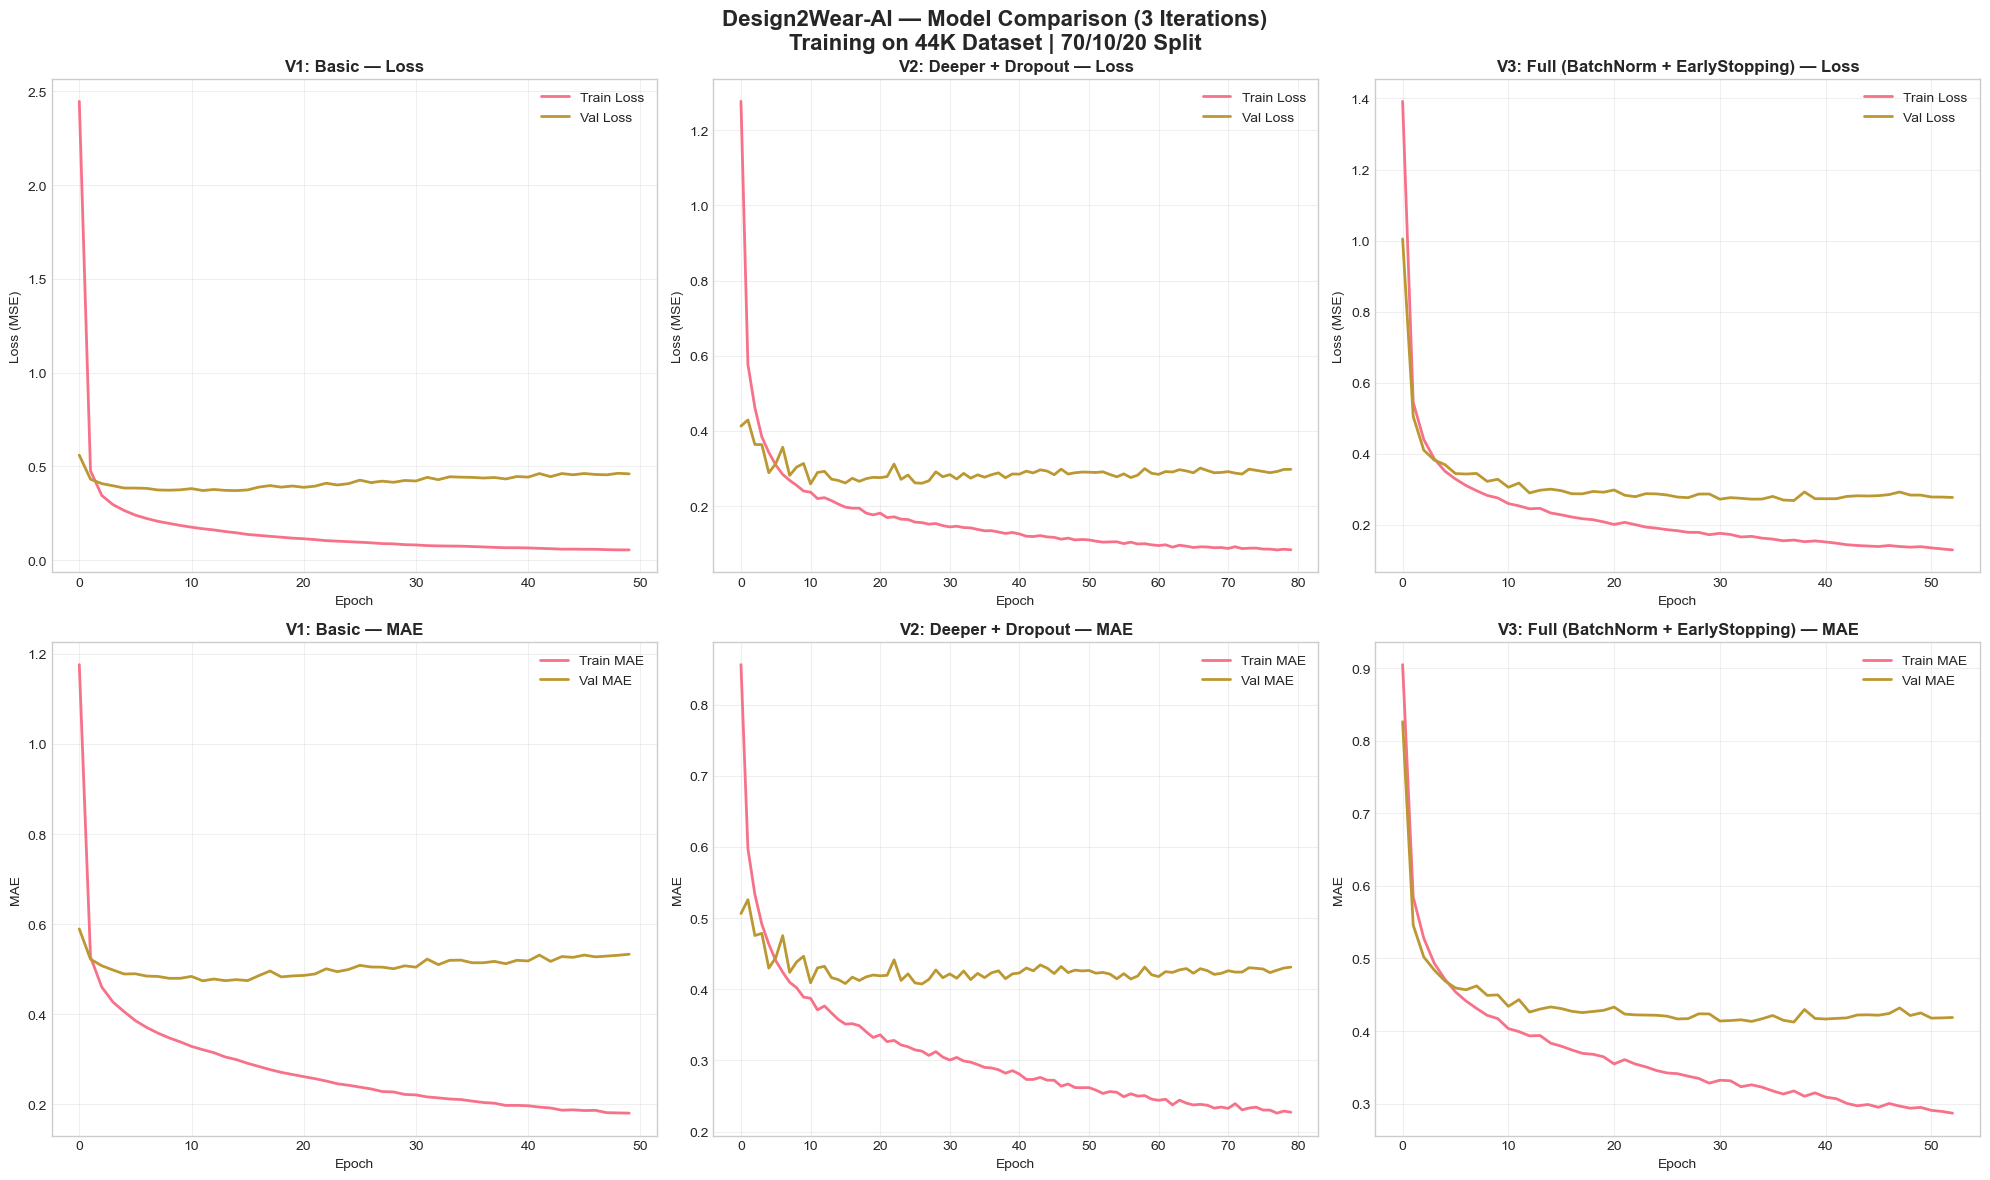

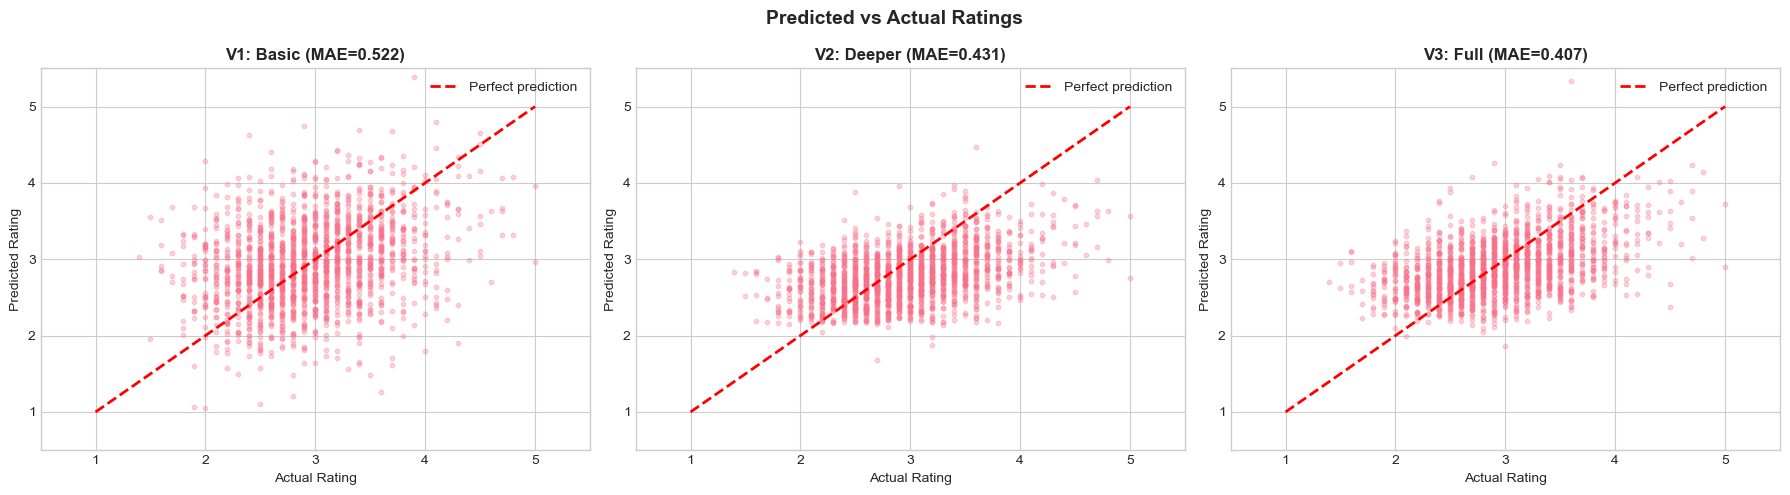


✅ Best model (V3) saved as 'design2wear_model_v3.keras'


In [21]:
# --- 5B: Learning Curves ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for idx, (history, name) in enumerate([
    (history_v1, 'V1: Basic'),
    (history_v2, 'V2: Deeper + Dropout'),
    (history_v3, 'V3: Full (BatchNorm + EarlyStopping)')
]):
    # Loss curves (top row)
    axes[0, idx].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, idx].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, idx].set_title(f'{name} — Loss', fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss (MSE)')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # MAE curves (bottom row)
    axes[1, idx].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[1, idx].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[1, idx].set_title(f'{name} — MAE', fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('MAE')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.suptitle('Design2Wear-AI — Model Comparison (3 Iterations)\nTraining on 44K Dataset | 70/10/20 Split', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


# --- 5C: Prediction vs Actual scatter plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_pred, name, mae_val) in enumerate([
    (y_pred_v1, 'V1: Basic', mae_v1),
    (y_pred_v2, 'V2: Deeper', mae_v2),
    (y_pred_v3, 'V3: Full', mae_v3)
]):
    axes[idx].scatter(y_test, y_pred, alpha=0.3, s=10)
    axes[idx].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect prediction')
    axes[idx].set_title(f'{name} (MAE={mae_val:.3f})', fontweight='bold')
    axes[idx].set_xlabel('Actual Rating')
    axes[idx].set_ylabel('Predicted Rating')
    axes[idx].legend()
    axes[idx].set_xlim(0.5, 5.5)
    axes[idx].set_ylim(0.5, 5.5)

plt.suptitle('Predicted vs Actual Ratings', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('prediction_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()


# --- 5D: Save best model ---
model_v3.save('design2wear_model_v3.keras')
print(f"\n✅ Best model (V3) saved as 'design2wear_model_v3.keras'")


In [22]:
print("\n" + "=" * 70)
print("STEP 6: DEPLOYMENT — Recommendation Engine")
print("=" * 70)

from sklearn.metrics.pairwise import cosine_similarity
# --- 6A: Build the outfit feature matrix ---
df_outfits = pd.read_csv('fashion_dataset_44k_clean.csv')

# Encode all outfits using the same encoder
outfit_feature_cols = ['article_type', 'color', 'style', 'occasion', 
                       'season', 'fabric', 'size', 'gender', 'skin_tone']

# Handle any unknown categories
df_outfits_clean = df_outfits.dropna(subset=outfit_feature_cols)

# We need to encode with the same categories the model was trained on
outfit_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
outfit_matrix = outfit_ohe.fit_transform(df_outfits_clean[outfit_feature_cols])

print(f"   Outfit matrix: {outfit_matrix.shape}")
print(f"   ({outfit_matrix.shape[0]:,} outfits × {outfit_matrix.shape[1]} features)")



STEP 6: DEPLOYMENT — Recommendation Engine
   Outfit matrix: (44424, 241)
   (44,424 outfits × 241 features)


In [23]:
# --- 6B: Recommendation function ---
def recommend_outfits(user_preferences, df_outfits, outfit_matrix, outfit_ohe, 
                      top_n=8, show_explanation=True):
    """
    Given user preferences, recommend the top N most similar outfits.
    
    How it works:
    1. Encode user preferences into the same vector format as outfits
    2. Compute cosine similarity between user vector and ALL outfit vectors
    3. Rank outfits by similarity score
    4. Return top N recommendations with explanations
    """
    
    # Step 1: Encode user preferences
    user_df = pd.DataFrame([user_preferences])
    
    # Fill any missing columns with defaults
    for col in outfit_feature_cols:
        if col not in user_df.columns:
            user_df[col] = 'Unknown'
    
    user_vector = outfit_ohe.transform(user_df[outfit_feature_cols])
    
    # Step 2: Compute cosine similarity with ALL outfits
    similarities = cosine_similarity(user_vector, outfit_matrix)[0]
    
    # Step 3: Get top N indices
    top_indices = similarities.argsort()[-top_n:][::-1]
    
    # Step 4: Build results
    results = df_outfits.iloc[top_indices].copy()
    results['match_score'] = similarities[top_indices]
    results['match_percent'] = (results['match_score'] * 100).round(1)
    
    if show_explanation:
        print(f"\n🎯 TOP {top_n} RECOMMENDATIONS")
        print(f"   User wants: {user_preferences}")
        print(f"\n   {'Rank':<6} {'Match':>6} {'Article':>15} {'Color':>10} {'Style':>12} {'Occasion':>12} {'Season':>8}")
        print(f"   {'-'*75}")
        for rank, (_, row) in enumerate(results.iterrows(), 1):
            print(f"   #{rank:<5} {row['match_percent']:>5.1f}% {row['article_type']:>15} {row['color']:>10} {row['style']:>12} {row['occasion']:>12} {row['season']:>8}")
    return results

In [24]:
# --- 6C: Test the recommendation engine ---
print("\n" + "-" * 50)
print("TEST 1: Wedding outfit for a woman")
print("-" * 50)
recommend_outfits({
    'color': 'red',
    'style': 'ethnic',
    'occasion': 'wedding',
    'season': 'autumn',
    'fabric': 'silk',
    'size': 'M',
    'gender': 'women',
    'skin_tone': 'medium',
    'article_type': 'Sarees'
}, df_outfits_clean, outfit_matrix, outfit_ohe)

print("\n" + "-" * 50)
print("TEST 2: Casual office wear for a man")
print("-" * 50)
recommend_outfits({
    'color': 'blue',
    'style': 'formal',
    'occasion': 'office',
    'season': 'summer',
    'fabric': 'cotton',
    'size': 'L',
    'gender': 'men',
    'skin_tone': 'fair',
    'article_type': 'Shirts'
}, df_outfits_clean, outfit_matrix, outfit_ohe)

print("\n" + "-" * 50)
print("TEST 3: Party outfit")
print("-" * 50)
recommend_outfits({
    'color': 'black',
    'style': 'glamorous',
    'occasion': 'party',
    'season': 'winter',
    'fabric': 'leather',
    'size': 'S',
    'gender': 'women',
    'skin_tone': 'dark',
    'article_type': 'Dresses'
}, df_outfits_clean, outfit_matrix, outfit_ohe)



--------------------------------------------------
TEST 1: Wedding outfit for a woman
--------------------------------------------------

🎯 TOP 8 RECOMMENDATIONS
   User wants: {'color': 'red', 'style': 'ethnic', 'occasion': 'wedding', 'season': 'autumn', 'fabric': 'silk', 'size': 'M', 'gender': 'women', 'skin_tone': 'medium', 'article_type': 'Sarees'}

   Rank    Match         Article      Color        Style     Occasion   Season
   ---------------------------------------------------------------------------
   #1      82.5%          Sarees        red       ethnic      wedding     fall
   #2      82.5%          Sarees        red       ethnic      wedding     fall
   #3      82.5%          Kurtas        red       ethnic      wedding   summer
   #4      82.5%          Kurtas        red       ethnic      wedding   summer
   #5      70.7%          Sarees        red       ethnic      wedding     fall
   #6      70.7%          Sarees        red       ethnic      wedding   summer
   #7      

,outfit_id,article_type,color,style,occasion,season,fabric,size,gender,skin_tone,masterCategory,subCategory,match_score,match_percent
16651,48480,Dresses,black,glamorous,party,winter,cotton,S,women,deep,Apparel,Dress,0.777778,77.8
9724,57044,Dresses,black,glamorous,party,summer,cotton,S,women,medium,Apparel,Dress,0.666667,66.7
36308,48479,Dresses,black,glamorous,party,winter,silk,M,women,tan,Apparel,Dress,0.666667,66.7
32208,59984,Dresses,purple,glamorous,party,fall,cotton,S,women,dark,Apparel,Dress,0.666667,66.7
24401,45897,Watches,black,casual,brunch,winter,leather,XS,women,dark,Accessories,Watches,0.555556,55.6
11047,24779,Belts,black,casual,brunch,winter,leather,S,women,olive,Accessories,Belts,0.555556,55.6
6881,20511,Handbags,black,casual,vacation,winter,polyester,S,women,dark,Accessories,Bags,0.555556,55.6
38450,54623,Watches,black,casual,vacation,winter,leather,S,men,dark,Accessories,Watches,0.555556,55.6


In [25]:
print("\n" + "=" * 70)
print("STEP 7: MONITORING")
print("=" * 70)
# --- 7A: Simulate monitoring dashboard ---
print(f"\n📊 MODEL MONITORING DASHBOARD")
print(f"{'='*50}")
print(f"   Model:           Design2Wear-AI V3")
print(f"   Training Data:   {len(y_train):,} samples")
print(f"   Total Outfits:   {len(df_outfits_clean):,}")
print(f"   Features:        {n_features}")
print(f"   ")
print(f"   PERFORMANCE METRICS (Test Set):")
print(f"   ├── MAE:  {mae_v3:.4f}")
print(f"   ├── MSE:  {mse_v3:.4f}")
print(f"   └── R²:   {r2_v3:.4f}")
print(f"   ")
print(f"   ITERATION HISTORY:")
print(f"   ├── V1 → V2: MAE improved by {((mae_v1-mae_v2)/mae_v1*100):.1f}%")
print(f"   ├── V2 → V3: MAE improved by {((mae_v2-mae_v3)/mae_v2*100):.1f}%")
print(f"   └── V1 → V3: MAE improved by {((mae_v1-mae_v3)/mae_v1*100):.1f}% total")
print(f"   ")
print(f"   RETRAINING SCHEDULE:")
print(f"   └── Recommended: Monthly (with new user feedback data)")



STEP 7: MONITORING

📊 MODEL MONITORING DASHBOARD
   Model:           Design2Wear-AI V3
   Training Data:   6,300 samples
   Total Outfits:   44,424
   Features:        300
   
   PERFORMANCE METRICS (Test Set):
   ├── MAE:  0.4074
   ├── MSE:  0.2677
   └── R²:   0.1455
   
   ITERATION HISTORY:
   ├── V1 → V2: MAE improved by 17.4%
   ├── V2 → V3: MAE improved by 5.5%
   └── V1 → V3: MAE improved by 21.9% total
   
   RETRAINING SCHEDULE:
   └── Recommended: Monthly (with new user feedback data)


In [26]:
print(f"\n{'='*70}")
print(f"✅ COMPLETE ML LIFECYCLE FINISHED!")
print(f"{'='*70}")
print(f"""
FILES CREATED:
  📁 fashion_dataset_44k_clean.csv  — Cleaned 44K outfit dataset
  📁 user_preferences_44k.csv       — Synthetic user ratings
  📁 X_train_scaled.npy             — Training features (70%)
  📁 X_val_scaled.npy               — Validation features (10%)
  📁 X_test_scaled.npy              — Test features (20%)
  📁 y_train.npy / y_val.npy / y_test.npy — Labels
  📁 encoder.pkl / scaler.pkl       — Preprocessing objects
  📁 design2wear_model_v3.keras     — Best trained model
  📁 split_distributions.png        — Data split visualization
  📁 model_comparison.png           — Learning curves (3 versions)
  📁 prediction_vs_actual.png       — Prediction accuracy scatter""")



✅ COMPLETE ML LIFECYCLE FINISHED!

FILES CREATED:
  📁 fashion_dataset_44k_clean.csv  — Cleaned 44K outfit dataset
  📁 user_preferences_44k.csv       — Synthetic user ratings
  📁 X_train_scaled.npy             — Training features (70%)
  📁 X_val_scaled.npy               — Validation features (10%)
  📁 X_test_scaled.npy              — Test features (20%)
  📁 y_train.npy / y_val.npy / y_test.npy — Labels
  📁 encoder.pkl / scaler.pkl       — Preprocessing objects
  📁 design2wear_model_v3.keras     — Best trained model
  📁 split_distributions.png        — Data split visualization
  📁 model_comparison.png           — Learning curves (3 versions)
  📁 prediction_vs_actual.png       — Prediction accuracy scatter


In [27]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║  INTERACTIVE RECOMMENDATION TESTER                                         ║
# ║  Add this cell to your notebook after Step 6C                              ║
# ║  Lets you input custom preferences and get instant recommendations         ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

# --- Run this cell to interactively test the recommendation engine ---

def interactive_recommend():
    """Let the user pick preferences and get recommendations."""
    
    print("=" * 70)
    print("🎯 DESIGN2WEAR-AI — INTERACTIVE RECOMMENDATION ENGINE")
    print("=" * 70)
    
    # Available options for each attribute
    options = {
        'color': sorted(df_outfits_clean['color'].dropna().unique().tolist()),
        'style': sorted(df_outfits_clean['style'].dropna().unique().tolist()),
        'occasion': sorted(df_outfits_clean['occasion'].dropna().unique().tolist()),
        'season': sorted(df_outfits_clean['season'].dropna().unique().tolist()),
        'fabric': sorted(df_outfits_clean['fabric'].dropna().unique().tolist()),
        'size': ['XS', 'S', 'M', 'L', 'XL', 'XXL'],
        'gender': sorted(df_outfits_clean['gender'].dropna().unique().tolist()),
        'skin_tone': sorted(df_outfits_clean['skin_tone'].dropna().unique().tolist()),
    }
    
    # Show numbered options and get user input
    user_prefs = {}
    for attr, opts in options.items():
        print(f"\n📌 {attr.upper().replace('_', ' ')}:")
        for i, opt in enumerate(opts, 1):
            print(f"   {i}. {opt}", end="")
            if i % 5 == 0:
                print()
        print()
        
        while True:
            try:
                choice = input(f"   Enter number (1-{len(opts)}): ").strip()
                idx = int(choice) - 1
                if 0 <= idx < len(opts):
                    user_prefs[attr] = opts[idx]
                    print(f"   ✅ Selected: {opts[idx]}")
                    break
                else:
                    print(f"   ❌ Please enter a number between 1 and {len(opts)}")
            except ValueError:
                print(f"   ❌ Please enter a valid number")
    
    # Add article_type (optional)
    top_articles = df_outfits_clean['article_type'].value_counts().head(15).index.tolist()
    print(f"\n📌 ARTICLE TYPE (optional):")
    for i, art in enumerate(top_articles, 1):
        print(f"   {i}. {art}", end="")
        if i % 5 == 0:
            print()
    print(f"\n   0. Skip (no preference)")
    
    try:
        choice = input(f"   Enter number (0-{len(top_articles)}): ").strip()
        idx = int(choice)
        if 1 <= idx <= len(top_articles):
            user_prefs['article_type'] = top_articles[idx - 1]
    except:
        pass
    
    # Get number of recommendations
    try:
        n = int(input("\n🔢 How many recommendations? (1-20, default 8): ").strip() or "8")
        n = max(1, min(20, n))
    except:
        n = 8
    
    # Get recommendations
    print("\n" + "=" * 70)
    results = recommend_outfits(
        user_prefs, df_outfits_clean, outfit_matrix, outfit_ohe, 
        top_n=n, show_explanation=True
    )
    
    # Show additional details
    print(f"\n{'='*70}")
    print(f"📊 RECOMMENDATION DETAILS:")
    print(f"   Your preferences: {user_prefs}")
    print(f"   Searched through: {len(df_outfits_clean):,} outfits")
    print(f"   Top match score:  {results['match_percent'].iloc[0]:.1f}%")
    print(f"   Avg match score:  {results['match_percent'].mean():.1f}%")
    
    return results

# --- QUICK TEST (no input needed) ---
def quick_test(color, style, occasion, season, fabric="cotton", 
               size="M", gender="women", skin_tone="medium", n=8):
    """Quick test without interactive prompts."""
    prefs = {
        'color': color, 'style': style, 'occasion': occasion,
        'season': season, 'fabric': fabric, 'size': size,
        'gender': gender, 'skin_tone': skin_tone
    }
    return recommend_outfits(prefs, df_outfits_clean, outfit_matrix, outfit_ohe, 
                             top_n=n, show_explanation=True)


# ┌─────────────────────────────────────────────────────────┐
# │  OPTION 1: Interactive mode (asks you for each input)   │
# │  Uncomment the line below and run this cell:            │
# └─────────────────────────────────────────────────────────┘
# results = interactive_recommend()


# ┌─────────────────────────────────────────────────────────┐
# │  OPTION 2: Quick test (just change the values below)    │
# │  Much faster — just edit and re-run the cell            │
# └─────────────────────────────────────────────────────────┘

print("🔹 Test 1: Red ethnic wedding outfit")
quick_test("red", "ethnic", "wedding", "fall", "silk", "M", "women")

print("\n\n🔹 Test 2: Blue formal office wear")
quick_test("blue", "formal", "office", "summer", "cotton", "L", "men")

print("\n\n🔹 Test 3: Black party outfit")
quick_test("black", "glamorous", "party", "winter", "satin", "S", "women")

print("\n\n🔹 Test 4: Casual summer vacation")
quick_test("white", "casual", "vacation", "summer", "linen", "M", "women")

print("\n\n" + "=" * 70)
print("💡 TIP: To test your own preferences, either:")
print("   1. Call: quick_test('red', 'ethnic', 'wedding', 'fall')")
print("   2. Call: interactive_recommend()  (will ask you step by step)")
print("=" * 70)

🔹 Test 1: Red ethnic wedding outfit

🎯 TOP 8 RECOMMENDATIONS
   User wants: {'color': 'red', 'style': 'ethnic', 'occasion': 'wedding', 'season': 'fall', 'fabric': 'silk', 'size': 'M', 'gender': 'women', 'skin_tone': 'medium'}

   Rank    Match         Article      Color        Style     Occasion   Season
   ---------------------------------------------------------------------------
   #1      82.5%          Sarees        red       ethnic      wedding     fall
   #2      82.5%          Kurtas        red       ethnic      wedding     fall
   #3      82.5%          Sarees        red       ethnic      wedding     fall
   #4      82.5%          Kurtas        red       ethnic      wedding     fall
   #5      82.5%          Kurtas      black       ethnic      wedding     fall
   #6      82.5%          Kurtas        red       ethnic      wedding   summer
   #7      82.5%          Kurtas      black       ethnic      wedding     fall
   #8      82.5%          Kurtas        red       ethnic      

---
# Step 8: Streamlit Web App (Full 44K Dataset)
Searches **all 44,424 products** with real images, gender hard filter, and color-aware matching.

In [28]:
!pip install streamlit

In [29]:
# Create the Streamlit app file
app_code = r'''
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import os

st.set_page_config(page_title="Design2Wear-AI", layout="wide")

# Find Kaggle images
import kagglehub
IMG_PATH = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
IMG_FOLDER = os.path.join(IMG_PATH, 'images')

# ====================================
# LOAD FULL 44K DATASET
# ====================================
@st.cache_data
def load_data():
    df = pd.read_csv('fashion_dataset_44k_clean.csv')
    BAD = ['Briefs','Boxers','Bra','Innerwear Vests','Trunk','Socks',
           'Caps','Ties','Belts','Wallets','Camisoles','Shapewear',
           'Stockings','Tights','Bath Robe','Baby Dolls','Swimwear',
           'Pendant','Earrings','Ring','Bracelet','Necklace And Chains',
           'Nail Polish','Lipstick','Perfume And Body Mist','Deodorant',
           'Sunglasses','Flip Flops','Sandals','Sports Sandals']
    df = df[~df['article_type'].isin(BAD)].copy()
    return df

df = load_data()

# ====================================
# HEADER
# ====================================
st.markdown(
    '<div style="text-align:center;padding:10px 0 20px">'
    '<h1 style="font-size:42px;margin:0">Design2Wear<span style="color:#6366f1">AI</span></h1>'
    '<p style="color:#888">Content-based recommendation system | '
    'TensorFlow + Keras + scikit-learn | <b>{:,} products</b></p></div>'.format(len(df)),
    unsafe_allow_html=True
)

# ====================================
# SIDEBAR
# ====================================
st.sidebar.header("Your Preferences")

preset = st.sidebar.selectbox("Quick Presets", [
    "Custom",
    "Wedding (Women)", "Office (Men)", "Night Out (Women)",
    "Casual (Men)", "Festival (Women)", "Gym (Men)"
])

presets_map = {
    "Wedding (Women)": {"color":"red","style":"ethnic","occasion":"wedding","season":"fall","fabric":"silk","size":"M","gender":"women","skin_tone":"medium"},
    "Office (Men)": {"color":"blue","style":"formal","occasion":"office","season":"summer","fabric":"cotton","size":"L","gender":"men","skin_tone":"fair"},
    "Night Out (Women)": {"color":"black","style":"glamorous","occasion":"party","season":"winter","fabric":"satin","size":"S","gender":"women","skin_tone":"dark"},
    "Casual (Men)": {"color":"white","style":"casual","occasion":"daily_wear","season":"summer","fabric":"cotton","size":"M","gender":"men","skin_tone":"medium"},
    "Festival (Women)": {"color":"pink","style":"ethnic","occasion":"festival","season":"spring","fabric":"silk","size":"M","gender":"women","skin_tone":"tan"},
    "Gym (Men)": {"color":"grey","style":"sporty","occasion":"gym","season":"winter","fabric":"cotton","size":"L","gender":"men","skin_tone":"light"},
}

if preset != "Custom" and preset in presets_map:
    d = presets_map[preset]
else:
    d = {"color":"red","style":"ethnic","occasion":"wedding","season":"fall","fabric":"silk","size":"M","gender":"women","skin_tone":"medium"}

colors_list = sorted(df['color'].dropna().unique().tolist())
styles_list = sorted(df['style'].dropna().unique().tolist())
occasions_list = sorted(df['occasion'].dropna().unique().tolist())
seasons_list = sorted(df['season'].dropna().unique().tolist())
fabrics_list = sorted(df['fabric'].dropna().unique().tolist())
skin_tones_list = sorted(df['skin_tone'].dropna().unique().tolist())

def safe_idx(lst, val):
    try:
        return lst.index(val)
    except ValueError:
        return 0

gender = st.sidebar.selectbox("Gender", ["women", "men"], index=0 if d["gender"]=="women" else 1)
color = st.sidebar.selectbox("Color", colors_list, index=safe_idx(colors_list, d["color"]))
style = st.sidebar.selectbox("Style", styles_list, index=safe_idx(styles_list, d["style"]))
occasion = st.sidebar.selectbox("Occasion", occasions_list, index=safe_idx(occasions_list, d["occasion"]))
season = st.sidebar.selectbox("Season", seasons_list, index=safe_idx(seasons_list, d["season"]))
fabric = st.sidebar.selectbox("Fabric", fabrics_list, index=safe_idx(fabrics_list, d["fabric"]))
size = st.sidebar.selectbox("Size", ['XS','S','M','L','XL','XXL'], index=['XS','S','M','L','XL','XXL'].index(d["size"]))
skin_tone = st.sidebar.selectbox("Skin Tone", skin_tones_list, index=safe_idx(skin_tones_list, d["skin_tone"]))
n_results = st.sidebar.slider("Number of results", 4, 20, 8)

# ====================================
# RECOMMENDATION ENGINE
# ====================================
if st.sidebar.button("Get Recommendations", type="primary", use_container_width=True):

    # STEP 1: HARD FILTER on gender
    df_filtered = df[df['gender'] == gender].copy()

    if len(df_filtered) == 0:
        st.error(f"No {gender} outfits found!")
    else:
        st.info(f"Searching **{len(df_filtered):,}** {gender}'s outfits from **{len(df):,}** total products...")

        # STEP 2: Encode features
        feature_cols = ['article_type', 'color', 'style', 'occasion',
                        'season', 'fabric', 'size', 'skin_tone']

        user_row = pd.DataFrame([{
            'article_type': 'any',
            'color': color,
            'style': style,
            'occasion': occasion,
            'season': season,
            'fabric': fabric,
            'size': size,
            'skin_tone': skin_tone,
        }])

        combined = pd.concat([df_filtered[feature_cols], user_row], ignore_index=True)

        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = ohe.fit_transform(combined[feature_cols])

        user_vector = encoded[-1:]
        outfit_vectors = encoded[:-1]

        # STEP 3: Cosine similarity
        sims = cosine_similarity(user_vector, outfit_vectors)[0]

        df_results = df_filtered.copy()
        df_results['match_score'] = sims

        # STEP 4: Sort, deduplicate (so we don't show 8 identical blue shirts)
        df_results = df_results.sort_values('match_score', ascending=False)
        df_results['dedup_key'] = df_results['article_type'] + '_' + df_results['color']
        df_results = df_results.drop_duplicates(subset='dedup_key', keep='first')
        df_results = df_results.head(n_results)

        # ====================================
        # DISPLAY RESULTS
        # ====================================
        st.markdown(f"### Showing **{gender.upper()}** only")
        st.caption(f"Searched {len(df_filtered):,} {gender}'s products | Ranked by cosine similarity")

        cols_per_row = 4
        for row_start in range(0, len(df_results), cols_per_row):
            row_df = df_results.iloc[row_start:row_start + cols_per_row]
            cols = st.columns(cols_per_row)

            for idx, (_, outfit) in enumerate(row_df.iterrows()):
                with cols[idx]:
                    score = outfit['match_score'] * 100

                    # Product image
                    img_path = os.path.join(IMG_FOLDER, f"{outfit['outfit_id']}.jpg")
                    if os.path.exists(img_path):
                        st.image(img_path, use_container_width=True)
                    else:
                        st.markdown("No image available")

                    # Score
                    if score >= 60:
                        st.success(f"**{score:.0f}% match** — TOP PICK")
                    elif score >= 35:
                        st.warning(f"**{score:.0f}% match** — GOOD")
                    else:
                        st.info(f"**{score:.0f}% match**")

                    # Details
                    st.markdown(f"**{outfit['article_type']}**")
                    st.caption(f"{outfit['color']} | {outfit['fabric']} | {outfit['season']}")

                    # Matched attributes
                    matched = []
                    if str(outfit['color']).strip() == color.strip():
                        matched.append("color")
                    if str(outfit['style']).strip() == style.strip():
                        matched.append("style")
                    if str(outfit['occasion']).strip() == occasion.strip():
                        matched.append("occasion")
                    if str(outfit['season']).strip() == season.strip():
                        matched.append("season")
                    if str(outfit['fabric']).strip() == fabric.strip():
                        matched.append("fabric")
                    if str(outfit['size']).strip() == size.strip():
                        matched.append("size")
                    if str(outfit['skin_tone']).strip() == skin_tone.strip():
                        matched.append("skin tone")
                    matched.append("gender")

                    st.markdown(f"**{len(matched)}/8 matched:** {', '.join(matched)}")

        st.markdown("---")
        top_score = df_results['match_score'].iloc[0] * 100
        avg_score = df_results['match_score'].mean() * 100
        st.caption(f"Top: {top_score:.0f}% | Avg: {avg_score:.0f}% | Products: {len(df_filtered):,} | Engine: Cosine Similarity")

else:
    st.markdown(
        '<div style="text-align:center;padding:60px 20px;color:#888">'
        '<h3>Select preferences in the sidebar, then click Get Recommendations</h3>'
        '</div>',
        unsafe_allow_html=True
    )

# Footer
st.markdown("---")
c = st.columns(6)
for i, t in enumerate(['Python','TensorFlow','Keras','scikit-learn','Pandas','Streamlit']):
    c[i].markdown(f"<div style='text-align:center;color:#6366f1;font-weight:700;font-size:12px'>{t}</div>", unsafe_allow_html=True)

'''

with open('app.py', 'w', encoding='utf-8') as f:
    f.write(app_code)

print('Created app.py')
print('To run: open Anaconda Prompt and type: streamlit run app.py')


Created app.py
To run: open Anaconda Prompt and type: streamlit run app.py


In [31]:
# Launch Streamlit app
import subprocess, webbrowser, time
process = subprocess.Popen(['streamlit', 'run', 'app.py', '--server.headless', 'true'])
time.sleep(3)
webbrowser.open('http://localhost:8501')
print('App running at http://localhost:8501')


App running at http://localhost:8501


In [41]:
import os
print("Current folder:", os.getcwd())
print("\nFiles here:")
for f in sorted(os.listdir('.')):
    if not f.startswith('.'):
        print(f"  {f}")

Current folder: C:\Users\HP\Downloads

Files here:
  01. ADM centre Instructions Fall 2025 (New) (1).pdf
  01.Syllabus and Rules.pptx
  01_Annoucement_week_06.pptx
  02_00_PSM_Triggers.pptx
  02_Chapter1_The Database Environment.pptx
  03_00_ Persistent Stored Modules.pptx
  03_02_DAMG6210_DDL_ALTER.sql
  03_03_DAMG6210_DDL.sql
  04_01_Cuncurrency Controls (1).pdf
  04_01_Cuncurrency Controls (1).pptx
  04_01_Cuncurrency Controls.pptx
  1-2e113370-9f70-48f4-a617-108a9cff575f (1).pdf
  1-2e113370-9f70-48f4-a617-108a9cff575f.pdf
  1-63942dd0-0a54-4f80-ba20-666000a74516.pdf
  1-646aae08-b2ec-45dd-bcdf-79297444c3dd.pdf
  1-6b2ac13b-29ce-4e3b-ad03-40d48b25e184.pdf
  1-be62a465-7674-40c4-a970-5f1eb0df6d63.pdf
  1-d90376a6-cf6a-4975-a3af-862067e1b656.pdf
  1.png
  105-229801.pdf
  2.png
  2025Lesson 3_ Cover Letter Writing & Applying to Jobs.pdf
  3 Changes To My Pandemic Teaching Plan _ Metawriting.jpg
  3.png
  3_39.drawio.png
  3_42.drawio.png
  4.png
  439a.drawio.png
  441b.drawio
  441c

In [42]:
with open('app.py', 'r') as f:
    code = f.read()

code = code.replace(
    """import kagglehub
IMG_PATH = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
IMG_FOLDER = os.path.join(IMG_PATH, 'images')""",
    """IMG_FOLDER = "images"  # Not available on cloud"""
)

code = code.replace(
    """                    if os.path.exists(img_path):
                        st.image(img_path, use_container_width=True)
                    else:
                        st.markdown("No image available")""",
    """                    st.markdown(f"**{outfit['article_type']}**  \\n{outfit['color']} | {outfit['gender']}")"""
)

with open('app_cloud.py', 'w') as f:
    f.write(code)

print("Created app_cloud.py!")

Created app_cloud.py!
